## Gaussian Process Latent Variable Model

The [Gaussian Process Latent Variable Model](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Gaussian_process_latent_variable_models) (GPLVM) is a dimensionality reduction method that uses a Gaussian process to learn a low-dimensional representation of (potentially) high-dimensional data. In the typical setting of Gaussian process regression, where we are given inputs $X$ and outputs $y$, we choose a kernel and learn hyperparameters that best describe the mapping from $X$ to $y$. In the GPLVM, we are not given $X$: we are only given $y$. So we need to learn $X$ along with the kernel hyperparameters.

We do not do maximum likelihood inference on $X$. Instead, we set a Gaussian prior for $X$ and learn the mean and variance of the approximate (gaussian) posterior $q(X|y)$. In this notebook, we show how this can be done using the `pyro.contrib.gp` module. In particular we reproduce a result described in [2].

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
# assert pyro.__version__.startswith('1.5.0')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(1)

### Dataset

The data we are going to use consists of [single-cell](https://en.wikipedia.org/wiki/Single-cell_analysis) [qPCR](https://en.wikipedia.org/wiki/Real-time_polymerase_chain_reaction) data for 48 genes obtained from mice (Guo *et al.*, [1]). This data is available at the [Open Data Science repository](https://github.com/sods/ods). The data contains 48 columns, with each column corresponding to (normalized) measurements of each gene. Cells differentiate during their development and these data were obtained at various stages of development. The various stages are labelled from the 1-cell stage to the 64-cell stage. For the 32-cell stage, the data is further differentiated into 'trophectoderm' (TE) and 'inner cell mass' (ICM). ICM further differentiates into 'epiblast' (EPI) and 'primitive endoderm' (PE) at the 64-cell stage. Each of the rows in the dataset is labelled with one of these stages.

In [2]:
# license: Copyright (c) 2014, the Open Data Science Initiative
# license: https://www.elsevier.com/legal/elsevier-website-terms-and-conditions
URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"

df = pd.read_csv(URL, index_col=0)
print("Data shape: {}\n{}\n".format(df.shape, "-" * 21))
print("Data labels: {}\n{}\n".format(df.index.unique().tolist(), "-" * 86))
print("Show a small subset of the data:")
df.head()

Data shape: (437, 48)
---------------------

Data labels: ['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE', '64 EPI']
--------------------------------------------------------------------------------------

Show a small subset of the data:


,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


### Modelling

First, we need to define the output tensor $y$. To predict values for all $48$ genes, we need $48$ Gaussian processes. So the required shape for $y$ is `num_GPs x num_data = 48 x 437`.

In [3]:
data = torch.tensor(df.values, dtype=torch.get_default_dtype())
# we need to transpose data to correct its shape
y = data.t()

Now comes the most interesting part. We know that the observed data $y$ has latent structure: in particular different datapoints correspond to different cell stages. We would like our GPLVM to learn this structure in an unsupervised manner. In principle, if we do a good job of inference then we should be able to discover this structure---at least if we choose reasonable priors. First, we have to choose the dimension of our latent space $X$. We choose $dim(X)=2$, since we would like our model to disentangle 'capture time' ($1$, $2$, $4$, $8$, $16$, $32$, and $64$) from cell branching types (TE, ICM, PE, EPI). Next, when we set the mean of our prior over $X$, we set the first dimension to be equal to the observed capture time. This will help the GPLVM discover the structure we are interested in and will make it more likely that that structure will be axis-aligned in a way that is easier for us to interpret.

In [4]:
capture_time = y.new_tensor([int(cell_name.split(" ")[0]) for cell_name in df.index.values])
# we scale the time into the interval [0, 1]
time = capture_time.log2() / 6

# we setup the mean of our prior over X
X_prior_mean = torch.zeros(y.size(1), 2)  # shape: 437 x 2
X_prior_mean[:, 0] = time

We will use a sparse version of Gaussian process inference to make training faster. Remember that we also need to define $X$ as a `Parameter` so that we can set a prior and guide (variational distribution) for it.

In [5]:
kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))

# we clone here so that we don't change our prior during the course of training
X = Parameter(X_prior_mean.clone())

# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 32)
gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

We will use the [autoguide()](http://docs.pyro.ai/en/dev/contrib.gp.html#pyro.contrib.gp.parameterized.Parameterized.autoguide) method from the [Parameterized](http://docs.pyro.ai/en/dev/contrib.gp.html#module-pyro.contrib.gp.parameterized) class to set an auto Normal guide for $X$.

In [6]:
# we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm.autoguide("X", dist.Normal)

### Inference

As mentioned in the [Gaussian Processes tutorial](gp.ipynb), we can use the helper function [gp.util.train](http://docs.pyro.ai/en/dev/contrib.gp.html#pyro.contrib.gp.util.train) to train a Pyro GP module. By default, this helper function uses the Adam optimizer with a learning rate of `0.01`.

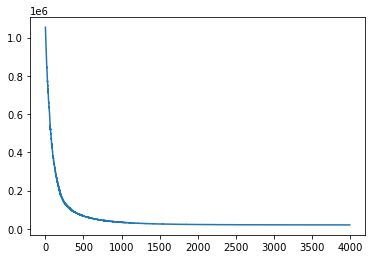

In [7]:
# note that training is expected to take a minute or so
losses = gp.util.train(gplvm, num_steps=4000)

# let's plot the loss curve after 4000 steps of training
plt.plot(losses)
plt.show()

After inference, the mean and standard deviation of the approximated posterior $q(X) \sim p(X | y)$ will be stored in the parameters `X_loc` and `X_scale`. To get a sample from $q(X)$, we need to set the `mode` of `gplvm` to `"guide"`.

In [8]:
gplvm.mode = "guide"
X = gplvm.X  # draw a sample from the guide of the variable X

### Visualizing the result

Let’s see what we got by applying GPLVM to our dataset.

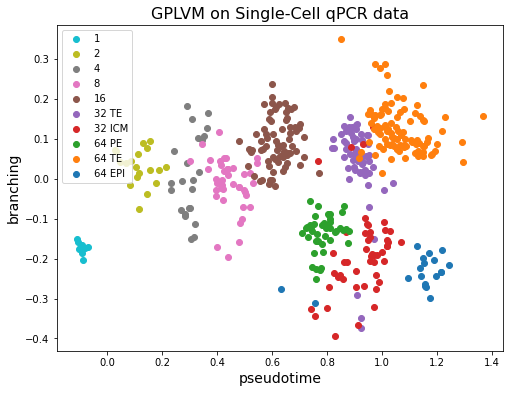

In [9]:
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = df.index.unique()

X = gplvm.X_loc.detach().numpy()
for i, label in enumerate(labels):
    X_i = X[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)

plt.legend()
plt.xlabel("pseudotime", fontsize=14)
plt.ylabel("branching", fontsize=14)
plt.title("GPLVM on Single-Cell qPCR data", fontsize=16)
plt.show()

We can see that the first dimension of the latent $X$ for each cell (horizontal axis) corresponds well with the observed capture time (colors). On the other hand, the 32 TE cell and 64 TE cell are clustered near each other. And the fact that ICM cells differentiate into PE and EPI can also be observed from the figure!

### Remarks

+ The sparse version scales well (linearly) with the number of data points. So the GPLVM can be used with large datasets. Indeed in [2] the authors have applied GPLVM to a dataset with 68k peripheral blood mononuclear cells.

+ Much of the power of Gaussian Processes lies in the function prior defined by the kernel. We recommend users try out different combinations of kernels for different types of datasets! For example, if the data contains periodicities, it might make sense to use a [Periodic kernel](http://docs.pyro.ai/en/dev/contrib.gp.html#periodic). Other kernels can also be found in the [Pyro GP docs](http://docs.pyro.ai/en/dev/contrib.gp.html#module-pyro.contrib.gp.kernels).

### References

[1] `Resolution of Cell Fate Decisions Revealed by Single-Cell Gene Expression Analysis from Zygote to Blastocyst`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Guoji Guo, Mikael Huss, Guo Qing Tong, Chaoyang Wang, Li Li Sun, Neil D. Clarke, Paul Robson

[2] `GrandPrix: Scaling up the Bayesian GPLVM for single-cell data`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Sumon Ahmed, Magnus Rattray, Alexis Boukouvalas

[3] `Bayesian Gaussian Process Latent Variable Model`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Michalis K. Titsias, Neil D. Lawrence

[4] `A novel approach for resolving differences in single-cell gene expression patterns from zygote to blastocyst`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Florian Buettner, Fabian J. Theis